### 1.1 Building a basic chatbot with Langgraph (Graph API)

In [34]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages # add_messages is a reducer
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model

from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

load_dotenv()
memory = MemorySaver()

In [3]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages`function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list, add_messages]

In [4]:
llm = ChatOpenAI(model="gpt-4o")

In [5]:
# Node functionality
def chatbot(state:State):
    return {'messages': [llm.invoke(state['messages'])]}

In [6]:
graph_builder = StateGraph(State)

# Create a node
graph_builder.add_node("LLMChatbot", chatbot)

# Establish edges
graph_builder.add_edge(START, "LLMChatbot")
graph_builder.add_edge("LLMChatbot", END)

# Complie graph
graph = graph_builder.compile()

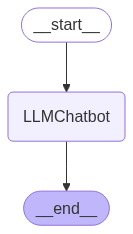

In [7]:
graph

In [8]:
response = graph.invoke({"messages":"Hi"})

In [9]:
response

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='405907bc-af35-4482-8410-64c74bd1e986'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_80956533cb', 'id': 'chatcmpl-C61T8LiQVLSt1gqJw8PuBnDedmLAw', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1aab71f6-d571-4b8b-bfc1-70b4e61c3c4c-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [10]:
response['messages'][-1].content

'Hello! How can I assist you today?'

In [11]:
for event in graph.stream({"messages": "Hi, how are you?"}):
    for value in event.values():
        print(value['messages'][-1].content)


Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


In [12]:
for event in graph.stream({"messages": "Can you give me some recent AI related news along with the date the news was published?"}):
    for value in event.values():
        print(value['messages'][-1].content)


I'm unable to provide real-time news or updates. However, I can suggest checking reputable news sources or technology news websites for the latest developments in AI. Websites like TechCrunch, Wired, The Verge, or the technology sections of major news organizations like BBC, The New York Times, or The Guardian often cover the latest in AI advancements, research, and news.


### 1.2 Chatbot with tools

In [13]:
searchtool = TavilySearch(max_results=2)
searchtool.invoke("What is langgraph?")

{'query': 'What is langgraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interactio

In [14]:
def multiply(a:int, b:int)->int:
    """
    Multiple a with b.

    a (int): First integer
    b (int): Second integer

    Returns:
        int: output integer product
    """
    return int(a*b)

In [15]:
tools=[searchtool, multiply]
llm_with_tools=llm.bind_tools(tools)

In [16]:
def tools_calling_llm(state:State):
    return {"messages": llm_with_tools.invoke(state['messages'])}

### New StateGraph
builder = StateGraph(State)

## Add Nodes
builder.add_node("ToolCallLLM", tools_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Add Edges
builder.add_edge(START, "ToolCallLLM")
# If the lastest message from the assistant is a tool call, tools_condition routes to "Tools"
# If the lastest message from the assistant is not a tool call, tools_condition routes to "END"
builder.add_conditional_edges("ToolCallLLM", tools_condition)
builder.add_edge("tools", END)

# Compile graph
new_graph = builder.compile()

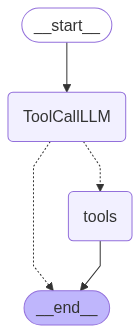

In [17]:
new_graph

In [18]:
new_response = new_graph.invoke({"messages": "Give recent AI news along with the date the news was published."})

In [19]:
new_response['messages'][-1].content

'{"query": "AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.foxnews.com/tech/fox-news-ai-newsletter-trump-admin-unveils-groundbreaking-tool-supercharging-govt-efficiency-ai", "title": "Fox News AI Newsletter: Trump admin unveils groundbreaking tool \'supercharging\' gov\'t efficiency in AI - Fox News", "score": 0.6052631, "published_date": "Sat, 16 Aug 2025 13:00:06 GMT", "content": "Right Arrow\\n\\nArtificial Intelligence Newsletter\\nFox News AI Newsletter: Trump admin unveils groundbreaking tool \'supercharging\' gov\'t efficiency in AI\\n======================================================================================================\\n\\nStay up to date on the latest AI technology advancements and learn about the challenges and opportunities AI presents\\n--------------------------------------------------------------------------------------------------------------------- [...] \'MUCH SMARTER\': Geoffrey Hinton, one of the

In [20]:
import json
json.loads(new_response['messages'][-1].content)['results']

[{'url': 'https://www.foxnews.com/tech/fox-news-ai-newsletter-trump-admin-unveils-groundbreaking-tool-supercharging-govt-efficiency-ai',
  'title': "Fox News AI Newsletter: Trump admin unveils groundbreaking tool 'supercharging' gov't efficiency in AI - Fox News",
  'score': 0.6052631,
  'published_date': 'Sat, 16 Aug 2025 13:00:06 GMT',
  'content': 'Right Arrow\n\nArtificial Intelligence Newsletter\nFox News AI Newsletter: Trump admin unveils groundbreaking tool \'supercharging\' gov\'t efficiency in AI\n======================================================================================================\n\nStay up to date on the latest AI technology advancements and learn about the challenges and opportunities AI presents\n--------------------------------------------------------------------------------------------------------------------- [...] \'MUCH SMARTER\': Geoffrey Hinton, one of the most prominent figures in the world of artificial intelligence, is sounding the alarm that ma

In [21]:
for m in new_response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give recent AI news along with the date the news was published.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_0EAEd1N38UsoSyEPiyCC9cvt)
 Call ID: call_0EAEd1N38UsoSyEPiyCC9cvt
  Args:
    query: AI news
    search_depth: advanced
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.foxnews.com/tech/fox-news-ai-newsletter-trump-admin-unveils-groundbreaking-tool-supercharging-govt-efficiency-ai", "title": "Fox News AI Newsletter: Trump admin unveils groundbreaking tool 'supercharging' gov't efficiency in AI - Fox News", "score": 0.6052631, "published_date": "Sat, 16 Aug 2025 13:00:06 GMT", "content": "Right Arrow\n\nArtificial Intelligence News

In [22]:
multiply_response = new_graph.invoke({"messages": "What is 2 multipled by 10?"})

In [23]:
for m1 in multiply_response['messages']:
    m1.pretty_print()

================================ Human Message =================================

What is 2 multipled by 10?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ZyxoDyuI2iRZq5jdXRD4sWl0)
 Call ID: call_ZyxoDyuI2iRZq5jdXRD4sWl0
  Args:
    a: 2
    b: 10
================================= Tool Message =================================
Name: multiply

20


#### 1.2.1 What's missing in above scenario?

If the bot is asked a complex query like `Give recent AI news along with the date the news was published. Then multiply 2 by 10.`, it will fail to do both the jobs. It will mostly complete the job given first in seqeuence i.e., the AI news part. Since the current graph flow directly ends after performing one task. Ideally, there should be some kind of recursive flow which allows for recursive calls to the `ToolsNode` until all the tasks in the given user query are served/completed.

Enter ReAct Agent

### 1.3 ReAct Architecture

In [26]:
### New StateGraph
new_builder = StateGraph(State)

## Add Nodes
new_builder.add_node("ToolCallLLM", tools_calling_llm)
new_builder.add_node("tools", ToolNode(tools))

## Add Edges
new_builder.add_edge(START, "ToolCallLLM")
# If the lastest message from the assistant is a tool call, tools_condition routes to "Tools"
# If the lastest message from the assistant is not a tool call, tools_condition routes to "END"
new_builder.add_conditional_edges("ToolCallLLM", tools_condition)
new_builder.add_edge("tools", "ToolCallLLM")

# Compile graph
react_graph = new_builder.compile()

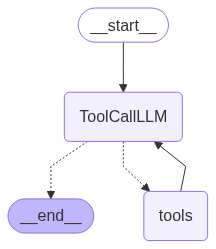

In [27]:
react_graph

In [32]:
react_response = react_graph.invoke({"messages": "Give recent AI news along with the date the news was published. Then multiply 2 by 50."})

In [33]:
for m in react_response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give recent AI news along with the date the news was published. Then multiply 2 by 50.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_0rUZgcr1EvC4kcCCKUpAHViZ)
 Call ID: call_0rUZgcr1EvC4kcCCKUpAHViZ
  Args:
    query: recent AI news
    topic: news
  multiply (call_Fru687JSeoSVfvVvI24BcVv1)
 Call ID: call_Fru687JSeoSVfvVvI24BcVv1
  Args:
    a: 2
    b: 50
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.telecoms.com/digital-ecosystem/ai?page=29", "title": "AI recent news | page 29 of 29 | Telecoms - Telecoms.com", "score": 0.72768575, "published_date": "Wed, 13 Aug 2025 11:27:25 GMT", "content": "AI recent news | page 29 of 29 | Telecoms Image 1 TechTarget and Inform

### 1.4 Memory In Langchain.
Until the previous architecture, follow-up questions or queries may not be answered correctly because the LLM might not be able to remember the information from previous conversations. To enable this feature

_add to imports the following command_<break>
`from langchain.checkpoint.memory import MemorySaver`
`memory = MemorySaver()`

In [35]:
### New StateGraph
mem_enabled_react_builder = StateGraph(State)

## Add Nodes
mem_enabled_react_builder.add_node("ToolCallLLM", tools_calling_llm)
mem_enabled_react_builder.add_node("tools", ToolNode(tools))

## Add Edges
mem_enabled_react_builder.add_edge(START, "ToolCallLLM")
# If the lastest message from the assistant is a tool call, tools_condition routes to "Tools"
# If the lastest message from the assistant is not a tool call, tools_condition routes to "END"
mem_enabled_react_builder.add_conditional_edges("ToolCallLLM", tools_condition)
mem_enabled_react_builder.add_edge("tools", "ToolCallLLM")

# Compile graph
mem_enabled_react_graph = mem_enabled_react_builder.compile(checkpointer=memory)

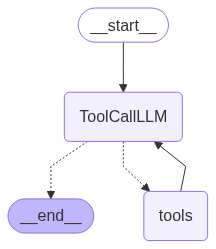

In [36]:
mem_enabled_react_graph

In [39]:
config = {"configurable": {"thread_id":"1"}}

In [40]:
mem_enabled_react_response = mem_enabled_react_graph.invoke({"messages": "Give recent AI news along with the date the news was published. Then multiply 2 by 50."}, config=config)

In [41]:
for m in mem_enabled_react_response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give recent AI news along with the date the news was published. Then multiply 2 by 50.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_hm7TjOPN8H9i8b0Hkd2koZws)
 Call ID: call_hm7TjOPN8H9i8b0Hkd2koZws
  Args:
    query: recent AI news
    topic: news
    search_depth: advanced
    time_range: week
  multiply (call_rfstN0JTwv3ptVnAoqw0cNL2)
 Call ID: call_rfstN0JTwv3ptVnAoqw0cNL2
  Args:
    a: 2
    b: 50
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.livescience.com/technology/artificial-intelligence/meta-ai-takes-first-step-to-superintelligence-and-zuckerberg-will-no-longer-release-the-most-powerful-systems-to-the-public", "title": "Meta AI takes first step to super

In [42]:
mem_enabled_react_response1 = mem_enabled_react_graph.invoke({"messages": "What tasks did I give you previously?"}, config=config)
for m in mem_enabled_react_response1['messages']:
    m.pretty_print()

================================ Human Message =================================

Give recent AI news along with the date the news was published. Then multiply 2 by 50.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_hm7TjOPN8H9i8b0Hkd2koZws)
 Call ID: call_hm7TjOPN8H9i8b0Hkd2koZws
  Args:
    query: recent AI news
    topic: news
    search_depth: advanced
    time_range: week
  multiply (call_rfstN0JTwv3ptVnAoqw0cNL2)
 Call ID: call_rfstN0JTwv3ptVnAoqw0cNL2
  Args:
    a: 2
    b: 50
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.livescience.com/technology/artificial-intelligence/meta-ai-takes-first-step-to-superintelligence-and-zuckerberg-will-no-longer-release-the-most-powerful-systems-to-the-public", "title": "Meta AI takes first step to super

In [49]:
## check how exactly the context is stored in the memory.
memory.blobs

defaultdict(None,
            {('1',
              '',
              '__start__',
              '00000000000000000000000000000001.0.37280628183756026'): ('msgpack',
              b'\x81\xa8messages\xd9VGive recent AI news along with the date the news was published. Then multiply 2 by 50.'),
             ('1',
              '',
              '__start__',
              '00000000000000000000000000000002.0.8079501536306988'): ('empty',
              b''),
             ('1',
              '',
              'messages',
              '00000000000000000000000000000002.0.8079501536306988'): ('msgpack',
              b'\x91\xc8\x01\n\x05\x94\xbdlangchain_core.messages.human\xacHumanMessage\x87\xa7content\xd9VGive recent AI news along with the date the news was published. Then multiply 2 by 50.\xb1additional_kwargs\x80\xb1response_metadata\x80\xa4type\xa5human\xa4name\xc0\xa2id\xd9$ccac6cfe-5349-4e24-a3dd-1a5e4f61c200\xa7example\xc2\xb3model_validate_json'),
             ('1',
              '',
 

### 1.5 Streaming in Langchain

In [50]:
streaming_memory = MemorySaver()

In [51]:
def superbot(state:State):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

In [52]:
streaming_graph = StateGraph(State)

# node
streaming_graph.add_node("SuperBot", superbot)

# edges
streaming_graph.add_edge(START, "SuperBot")
streaming_graph.add_edge("SuperBot", END)

compiled_streaming_graph = streaming_graph.compile(checkpointer=streaming_memory)

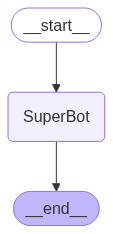

In [53]:
compiled_streaming_graph

In [54]:
# define config
streaming_config = {"configurable": {"thread_id": "1"}}

In [56]:
compiled_streaming_graph.invoke({"messages": "Hi, My name is AJ and I am a GenAI Engineer."}, config=streaming_config)

{'messages': [HumanMessage(content='Hi, My name is AJ and I am a GenAI Engineer.', additional_kwargs={}, response_metadata={}, id='838d0c78-cf02-4fa8-85ae-55b3b74089c4'),
  AIMessage(content="Hi AJ! It's great to meet you. Being a GenAI Engineer sounds fascinating. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 1319, 'total_tokens': 1344, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_df0f7b956c', 'id': 'chatcmpl-C62ALmLbpAA27fnMitZXVyqoOrapA', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1f665a97-77eb-458e-a3f9-1d6070c9b5b3-0', usage_metadata={'input_tokens': 1319, 'output_tokens': 25, 'total_tokens': 1344, 'input_token_details': {'audio':

##### **Streaming Methods**
Methods: .stream() and astream()

- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

- **values** : This streams the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.

In [57]:
# define config
streaming_config1 = {"configurable": {"thread_id": "2"}}

for chunk in compiled_streaming_graph.stream({"messages": "Hi, My name is AJ and I am a GenAI Engineer."}, config=streaming_config1, stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hello AJ! It's great to meet you. Being a GenAI Engineer sounds interesting and innovative. If there's anything specific you'd like to discuss or explore, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 1319, 'total_tokens': 1357, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_df0f7b956c', 'id': 'chatcmpl-C62N3jToO3P0GL3YVLBkzoTU8tKyM', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--405d4876-ec58-4c13-9338-820eb9ea1d94-0', usage_metadata={'input_tokens': 1319, 'output_tokens': 38, 'total_tokens': 1357, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoni

In [58]:
for chunk in compiled_streaming_graph.stream({"messages": "Hi, My name is AJ and I am a GenAI Engineer."}, config=streaming_config1, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is AJ and I am a GenAI Engineer.', additional_kwargs={}, response_metadata={}, id='0e938283-6672-4d94-87ea-599ed1ec833d'), AIMessage(content="Hello AJ! It's great to meet you. Being a GenAI Engineer sounds interesting and innovative. If there's anything specific you'd like to discuss or explore, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 1319, 'total_tokens': 1357, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_df0f7b956c', 'id': 'chatcmpl-C62N3jToO3P0GL3YVLBkzoTU8tKyM', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--405d4876-ec58-4c13-9338-820eb9ea1d94-0', usage_metadata={'input_tokens': 1319

In [60]:
# define config
streaming_config2 = {"configurable": {"thread_id": "4"}}

for chunk in compiled_streaming_graph.stream({"messages": "Hi, My name is AJ and I am a GenAI Engineer."}, config=streaming_config2, stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hi AJ! It's great to meet you. Being a GenAI Engineer sounds fascinating. If there's anything specific you'd like to discuss or explore, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 1319, 'total_tokens': 1355, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1280}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_df0f7b956c', 'id': 'chatcmpl-C62QtPTn4ifWVu6cAyiyYhKDR1elu', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--2388dfd9-e911-4456-8944-ffef1c75e0b2-0', usage_metadata={'input_tokens': 1319, 'output_tokens': 36, 'total_tokens': 1355, 'input_token_details': {'audio': 0, 'cache_read': 1280}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}

In [61]:

for chunk in compiled_streaming_graph.stream({"messages": "I also like Indian Classical Music."}, config=streaming_config2, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is AJ and I am a GenAI Engineer.', additional_kwargs={}, response_metadata={}, id='c8f31534-20a9-408b-9bbb-8a4d4e1999f3'), AIMessage(content="Hi AJ! It's great to meet you. Being a GenAI Engineer sounds fascinating. If there's anything specific you'd like to discuss or explore, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 1319, 'total_tokens': 1355, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1280}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_df0f7b956c', 'id': 'chatcmpl-C62QtPTn4ifWVu6cAyiyYhKDR1elu', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--2388dfd9-e911-4456-8944-ffef1c75e0b2-0', usage_metadata={'input_tokens': 1319, 'output_token

In [63]:
# define config
streaming_config3 = {"configurable": {"thread_id": "5"}}

async for chunk in compiled_streaming_graph.astream_events({"messages": "Hi, My name is AJ and I am a GenAI Engineer."}, config=streaming_config3, version="v1"):
    print(chunk)

{'event': 'on_chain_start', 'run_id': '9eee15f2-133f-4083-880c-40301520a63a', 'name': 'LangGraph', 'tags': [], 'metadata': {'thread_id': '5'}, 'data': {'input': {'messages': 'Hi, My name is AJ and I am a GenAI Engineer.'}}, 'parent_ids': []}
{'event': 'on_chain_start', 'name': 'SuperBot', 'run_id': 'a327cee2-ed7c-4237-b2ca-6dd17d2920a2', 'tags': ['graph:step:1'], 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:3a916149-a168-c979-ee3c-1811c87213d5'}, 'data': {'input': {'messages': [HumanMessage(content='Hi, My name is AJ and I am a GenAI Engineer.', additional_kwargs={}, response_metadata={}, id='8f2a0df9-c3f6-44d4-a447-588e393c48f1')]}}, 'parent_ids': []}
{'event': 'on_chat_model_start', 'name': 'ChatOpenAI', 'run_id': '297d99a7-594d-45ff-a6bb-84e9b99fcd2e', 'tags': ['seq:step:1'], 'metadata': {'thread_id': '5', 'langgrap

================================================= END =================================================